# Metadata

```
Course:   DS 5001
Module:   10 Lab
Topic:    Sentiment Analysis of Novels 
Author:   R.C. Alvarado

Purpose:  Use the NRC lexicon to explore sentiment in two novels.
```

# Set Up

In [1]:
data_home = '../data'
data_prefix = 'airbnb'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px
from IPython.display import display, HTML

In [3]:
sns.set()

# Get Lexicons

In [4]:
ls ../data/salex/

salex_bing.csv     salex_gi.csv       salex_nrc.csv      sources/
salex_combo.csv    salex_labmt.csv    salex_syuzhet.csv


In [5]:
SALEX = pd.read_csv(f'{data_home}/salex/salex_combo.csv').drop_duplicates(subset=['term_str'], keep='last').set_index('term_str')
if len(set([idx.lower() for idx in SALEX.index])) == len(SALEX.index):
    SALEX.index = [idx.lower() for idx in SALEX.index]
assert SALEX.index.is_unique

In [6]:
SALEX

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,nrc_polarity,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment,labmt_happiness,labmt_z
#epicpetwars,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.54,-1.769874
#fact,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.30,-1.069351
#fail,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.62,-3.539615
#fb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.12,-1.235265
#ff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.64,-1.677700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.32,-1.050917
zoo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.62,0.147345
zou,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.69,-1.631613
zu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00,-1.345873


# Get Ads

These are actually *not* reviews.

In [7]:
DOC_SRC = pd.read_csv(f"{data_home}/{data_prefix}/{data_prefix}.csv", sep='|').set_index('doc_key').dropna(subset=['doc_content'])

In [8]:
DOC_SRC.doc_label.value_counts()

Paris                         35086
London                        22243
Los Angeles                   10338
San Francisco                  6334
New Orleans                    2639
                              ...  
St John's Estate                  1
Dalston London                    1
London Fields                     1
 London Borough of Hackney        1
Wandsworth Town                   1
Name: doc_label, Length: 812, dtype: int64

## Pick useful features

In [9]:
doc_cols = "doc_price doc_rating doc_content".split()

## Sample observations from London and LA

In [10]:
cities = []
for city in ['London', 'Los Angeles']:
    df = DOC_SRC[(DOC_SRC.doc_label == city) 
       & (DOC_SRC.doc_price > 0)
       & (DOC_SRC.doc_content.str.len() > 200)
       & (DOC_SRC.doc_rating > 0)].sample(7000)[doc_cols]
    df['city_id'] = city
    cities.append(df)
DOC = pd.concat(cities)

In [11]:
DOC

,doc_price,doc_rating,doc_content,city_id
doc_key,,,,
1858254,86,98.0,My spacious & modern 1BD flat has everything y...,London
5798888,53,80.0,Room suits one but can easily fit two on the d...,London
2951877,42,99.0,You'll find our quiet and comfortable double r...,London
5589276,110,93.0,Newly refurbished studio flat in the iconic Go...,London
7105527,40,76.0,Beautiful and bright double room in Bethnal gr...,London
...,...,...,...,...
5421752,120,93.0,A modern top-floor apartment right by Los Fel...,Los Angeles
7699517,100,100.0,Our comfortable one bedroom exposed-brick flat...,Los Angeles
6328058,95,88.0,Beautiful apartment studio in downtown LA area...,Los Angeles


# Create Count and TFIDF Matrices

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [13]:
VSHORT = SALEX[SALEX.index.str.match(r'^[A-Za-z]+$') & (SALEX.index.str.len() >= 4) & (SALEX.index.str.len() <= 12)].index

In [14]:
len(VSHORT)

17823

In [15]:
count_engine = CountVectorizer(vocabulary=VSHORT, stop_words='english')
count_model = count_engine.fit_transform(DOC.doc_content)

In [16]:
DOC_TERM_COUNT = pd.DataFrame(count_model.toarray(), index=DOC.index, columns=count_engine.get_feature_names_out())
DOC_TERM_COUNT = DOC_TERM_COUNT[VSHORT[DOC_TERM_COUNT.sum() > 0]]

In [17]:
DOC_TERM_P = (DOC_TERM_COUNT.T / DOC_TERM_COUNT.T.sum()).T

In [18]:
tfidf_engine = TfidfTransformer()
tfidf_model = tfidf_engine.fit_transform(count_model)

In [19]:
DOC_TFIDF = pd.DataFrame(tfidf_model.toarray(), index=DOC.index, columns=count_engine.get_feature_names_out())
DOC_TFIDF = DOC_TFIDF[VSHORT[DOC_TFIDF.sum() > 0]]

In [20]:
DOC_TERM_COUNT.head()

,abide,abilities,ability,able,aboard,abound,abounds,abroad,absence,absent,...,youth,youthful,youtube,youu,yummy,zenith,zero,zest,zion,zone
doc_key,,,,,,,,,,,,,,,,,,,,,
1858254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5798888,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2951877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5589276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7105527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
DOC_TFIDF.head()

,abide,abilities,ability,able,aboard,abound,abounds,abroad,absence,absent,...,youth,youthful,youtube,youu,yummy,zenith,zero,zest,zion,zone
doc_key,,,,,,,,,,,,,,,,,,,,,
1858254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5798888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2951877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5589276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7105527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Extract VOCAB 

In [22]:
VOCAB = DOC_TERM_COUNT.sum().to_frame('n')
VOCAB.index.name = 'term_str'
VOCAB.columns.name = 'stat'
VOCAB.n = VOCAB.n.fillna(0).astype('int')

In [23]:
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = np.log2(1/VOCAB.p)
VOCAB['h'] = VOCAB.p * VOCAB.i
VOCAB['df'] = DOC_TERM_COUNT[DOC_TERM_COUNT > 0].count()
VOCAB['dfidf'] = VOCAB.df * np.log2(len(DOC)/VOCAB.df)

In [24]:
VOCAB.sort_values('dfidf', ascending=False).head(10)

stat,n,p,i,h,df,dfidf
term_str,,,,,,
apartment,11044,0.011926,6.389693,0.076206,5199,7429.998867
london,10697,0.011552,6.435750,0.074344,5048,7428.853923
restaurants,6232,0.006730,7.215189,0.048558,5008,7427.466762
access,6666,0.007199,7.118063,0.051240,4978,7426.124107
located,7312,0.007896,6.984618,0.055152,5330,7425.859344
living,7361,0.007949,6.974982,0.055445,5368,7423.784305
area,6952,0.007507,7.057456,0.052984,4931,7423.495594
private,7868,0.008497,6.878887,0.058448,4736,7405.616143
street,6609,0.007137,7.130452,0.050891,4420,7351.823802


In [25]:
# (VOCAB.labmt_happiness * VOCAB.dfidf).dropna().sort_values(ascending=False).head(20)

## Add SALEX

In [26]:
try:
    VOCAB = VOCAB.join(SALEX)
except ValueError:
    pass

In [27]:
VOCAB

,n,p,i,h,df,dfidf,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,...,nrc_surprise,nrc_trust,nrc_polarity,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment,labmt_happiness,labmt_z
term_str,,,,,,,,,,,,,,,,,,,,,
abide,4,0.000004,17.820668,0.000077,4,47.092557,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
abilities,2,0.000002,18.820668,0.000041,2,25.546278,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.60,NaN,NaN,NaN
ability,23,0.000025,15.297106,0.000380,23,212.740277,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.50,1.0,6.68,0.202650
able,395,0.000427,11.194959,0.004775,372,1947.040707,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,6.56,0.092041
aboard,1,0.000001,19.820668,0.000021,1,13.773139,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.25,NaN,6.24,-0.202916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zenith,1,0.000001,19.820668,0.000021,1,13.773139,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,1.0,1.0,0.40,1.0,NaN,NaN
zero,25,0.000027,15.176812,0.000410,22,204.901567,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.44,-2.783788
zest,1,0.000001,19.820668,0.000021,1,13.773139,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,1.0,0.50,1.0,NaN,NaN


In [28]:
VOCAB['labmt_happiness_p'] = (VOCAB.p * VOCAB.labmt_happiness).dropna()

In [29]:
VOCAB

,n,p,i,h,df,dfidf,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,...,nrc_trust,nrc_polarity,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment,labmt_happiness,labmt_z,labmt_happiness_p
term_str,,,,,,,,,,,,,,,,,,,,,
abide,4,0.000004,17.820668,0.000077,4,47.092557,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
abilities,2,0.000002,18.820668,0.000041,2,25.546278,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.60,NaN,NaN,NaN,NaN
ability,23,0.000025,15.297106,0.000380,23,212.740277,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.50,1.0,6.68,0.202650,0.000166
able,395,0.000427,11.194959,0.004775,372,1947.040707,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,6.56,0.092041,0.002798
aboard,1,0.000001,19.820668,0.000021,1,13.773139,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.25,NaN,6.24,-0.202916,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zenith,1,0.000001,19.820668,0.000021,1,13.773139,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,1.0,1.0,0.40,1.0,NaN,NaN,NaN
zero,25,0.000027,15.176812,0.000410,22,204.901567,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.44,-2.783788,0.000093
zest,1,0.000001,19.820668,0.000021,1,13.773139,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,1.0,1.0,0.50,1.0,NaN,NaN,NaN


In [1]:
# px.scatter(VOCAB.reset_index(), 'labmt_happiness','labmt_happiness_p', hover_name='term_str', size='p', color='dfidf', height=500, width=700)

# Cities

## Ratings

In [37]:
CITY_RATINGS = DOC.value_counts(['city_id','doc_rating']).unstack().T.sort_index(ascending=False).fillna(0)
CITY_RATINGS.index.name = 'rating'
CITY_RATINGS.index = CITY_RATINGS.index.astype('int')
CITY_RATINGS.columns.name = 'city_id'
CITY_RATINGS = CITY_RATINGS.astype('int')

In [38]:
CITY_RATINGS

city_id,London,Los Angeles
rating,,
100,1626,2051
99,98,235
98,254,487
97,288,456
96,350,472
95,369,468
94,253,308
93,476,470
92,235,236


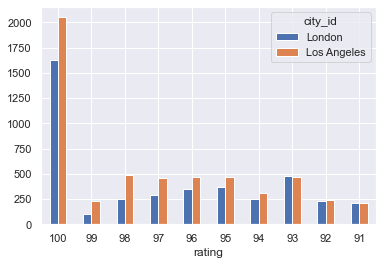

In [39]:
CITY_RATINGS.head(10).plot.bar(rot=0);

## Language Models

In [31]:
CITY_TERMS = DOC_TERM_COUNT.join(DOC.city_id).groupby('city_id').sum().T
CITY_TERMS.index.name = 'term_str'
# CITY_TERMS['both'] = CITY_TERMS.sum(1) # Already in VOCAB

In [32]:
CITY_TERMS

city_id,London,Los Angeles
term_str,,
abide,1,3
abilities,1,1
ability,13,10
able,229,166
aboard,1,0
...,...,...
zenith,0,1
zero,6,19
zest,1,0


In [33]:
CITY_TERMS_P = CITY_TERMS / CITY_TERMS.sum() # Conditional probs on city
CITY_TERMS_P['diff'] = CITY_TERMS_P['London'] - CITY_TERMS_P['Los Angeles']

In [34]:
CITY_TERMS_P.sort_values('diff')

city_id,London,Los Angeles,diff
term_str,,,
hollywood,0.000009,0.014517,-0.014508
parking,0.001361,0.008363,-0.007002
beach,0.000032,0.006824,-0.006792
private,0.005174,0.011850,-0.006676
downtown,0.000019,0.005425,-0.005406
...,...,...,...
tube,0.007000,0.000007,0.006993
station,0.008803,0.001211,0.007592
double,0.013763,0.000718,0.013045


In [35]:
CITY_TERMS_P[VOCAB.n > 10]

city_id,London,Los Angeles,diff
term_str,,,
ability,0.000028,0.000022,0.000006
able,0.000492,0.000360,0.000132
abound,0.000006,0.000052,-0.000046
abroad,0.000037,0.000013,0.000024
absolute,0.000017,0.000037,-0.000020
...,...,...,...
young,0.000447,0.000341,0.000106
youtube,0.000011,0.000063,-0.000052
yummy,0.000024,0.000043,-0.000020


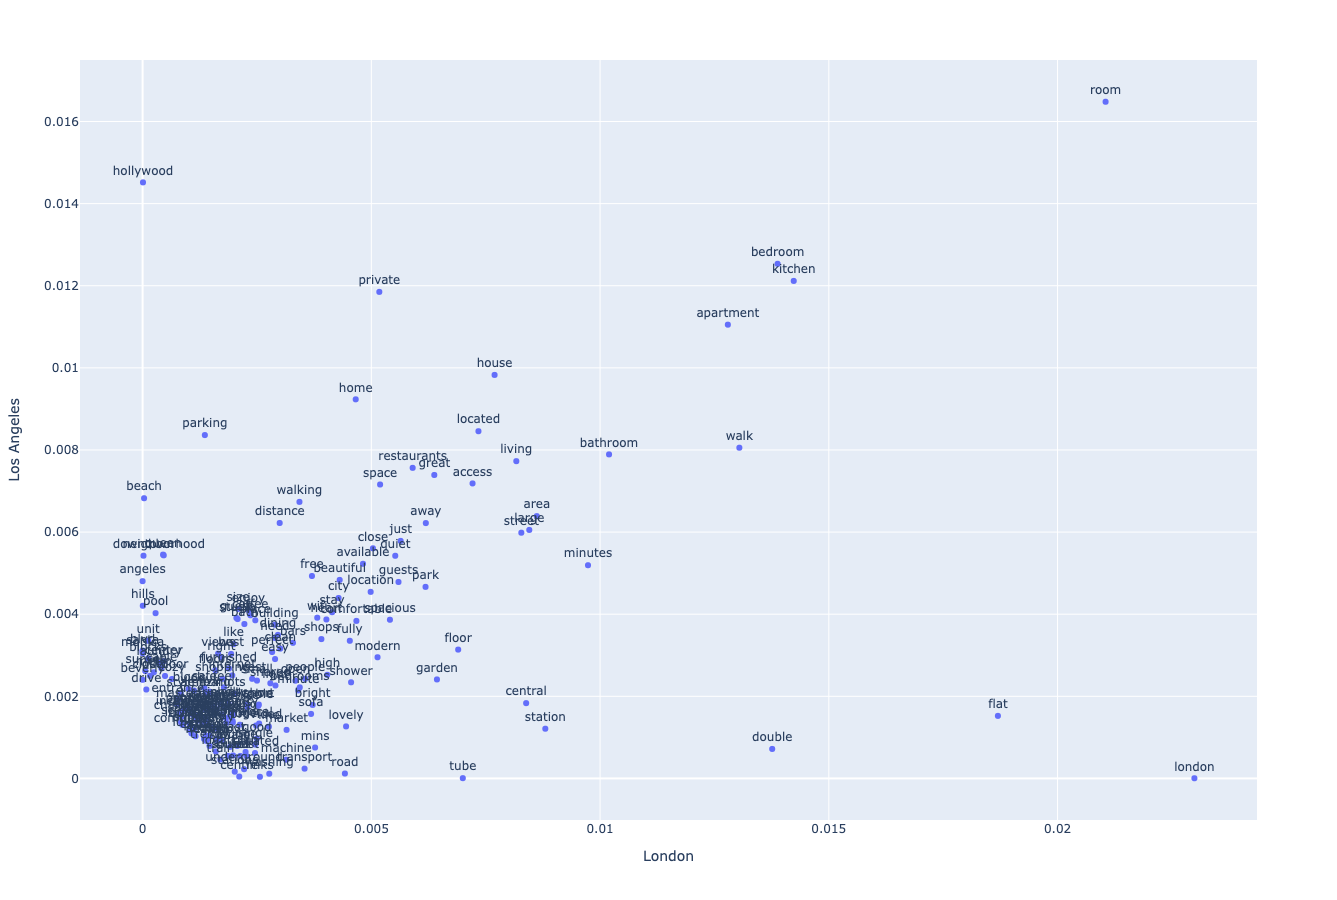

In [36]:
px.scatter(CITY_TERMS_P[VOCAB.n > 1000].reset_index(), 'London', 'Los Angeles', text='term_str', width=1000, height=900)\
    .update_traces(textposition='top center')

## Sentiment

In [40]:
CITY_PHI_LABMT = (CITY_TERMS_P.T * VOCAB.labmt_happiness).T.dropna()
CITY_PHI_NRC = (CITY_TERMS_P.T * VOCAB.nrc_polarity).T.dropna()
CITY_PHI_GI = (CITY_TERMS_P.T * VOCAB.gi_sentiment).T.dropna()
CITY_PHI_BING = (CITY_TERMS_P.T * VOCAB.bing_sentiment).T.dropna()

In [41]:
CITY_PHI_LABMT['y'] = (CITY_PHI_LABMT['diff'] * VOCAB.labmt_happiness_p).dropna()

In [42]:
CITY_PHI_LABMT.sort_values('y')

city_id,London,Los Angeles,diff,y
term_str,,,,
hollywood,0.000055,0.092037,-0.091983,-0.004216
private,0.030633,0.070152,-0.039519,-0.001988
home,0.033262,0.065924,-0.032662,-0.001617
beach,0.000256,0.054186,-0.053930,-0.001461
parking,0.006831,0.041982,-0.035151,-0.000855
...,...,...,...,...
walk,0.078529,0.048490,0.030039,0.001910
room,0.116199,0.090973,0.025225,0.002614
double,0.079824,0.004166,0.075658,0.003191


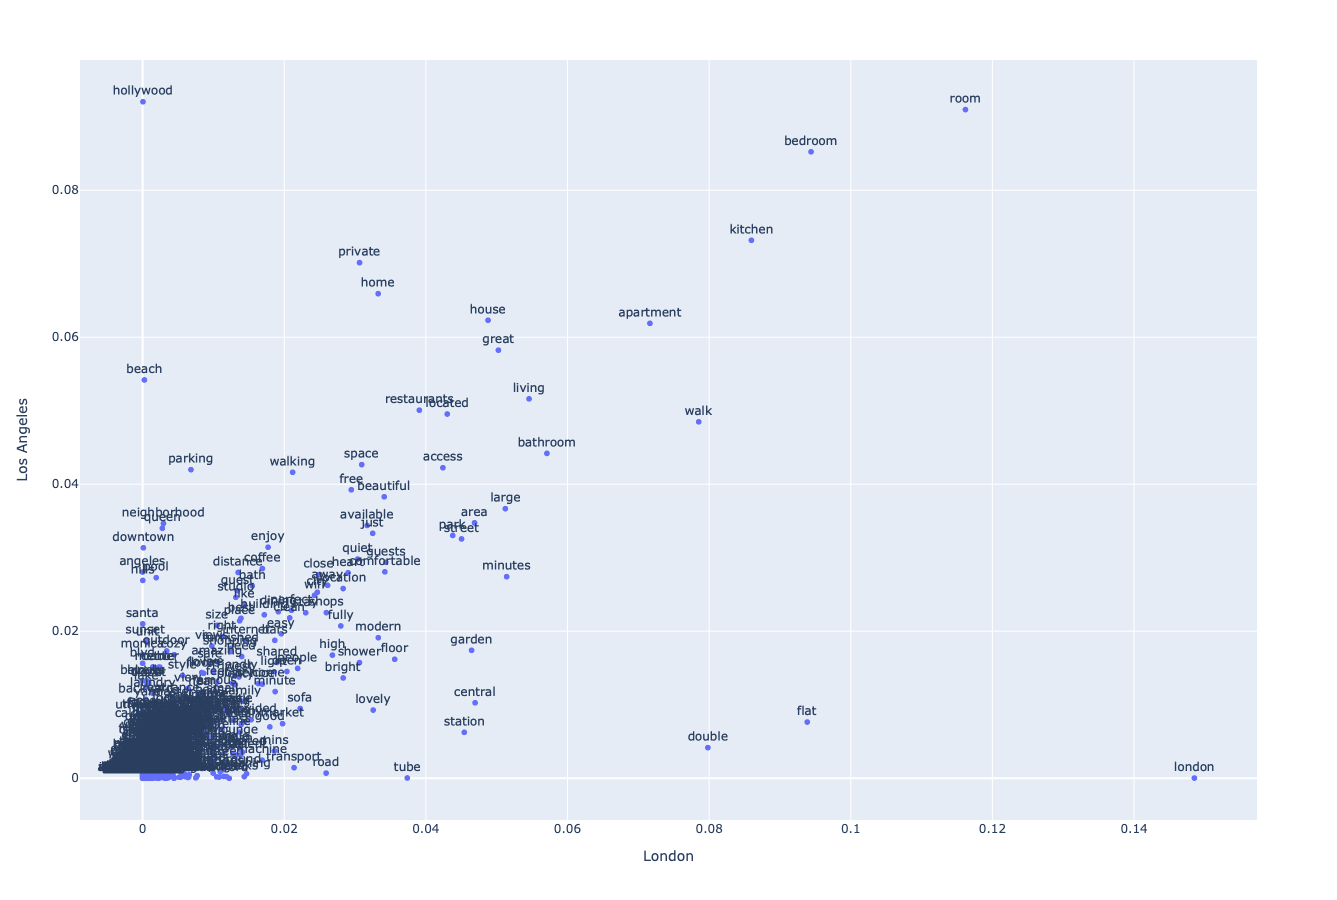

In [52]:
px.scatter(CITY_PHI_LABMT.reset_index(), 'London', 'Los Angeles', text='term_str', width=1000, height=900)\
    .update_traces(textposition='top center')

# Happiness and Word Shift Graphs

In [44]:
import shifterator

In [45]:
import sys; sys.path.append('/Users/rca2t1/Repos/shifterator/shifterator')
import shifterator as sh

In [50]:
def plot_shift(df, a, b):
    A = df.fillna(0).loc[a].to_dict()
    B = df.fillna(0).loc[b].to_dict()
    sentiment_shift = sh.WeightedAvgShift(A, B, 'labMT_English')
    sentiment_shift.get_shift_graph(system_names = [a, b])

In [53]:
CITY_TERMS

city_id,London,Los Angeles
term_str,,
abide,1,3
abilities,1,1
ability,13,10
able,229,166
aboard,1,0
...,...,...
zenith,0,1
zero,6,19
zest,1,0


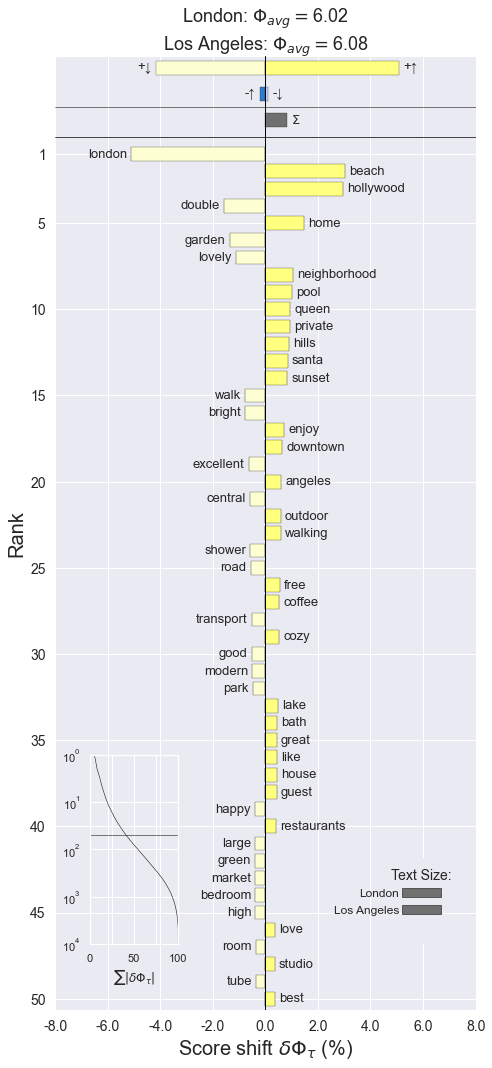

In [51]:
plot_shift(CITY_TERMS.T, 'London', 'Los Angeles')

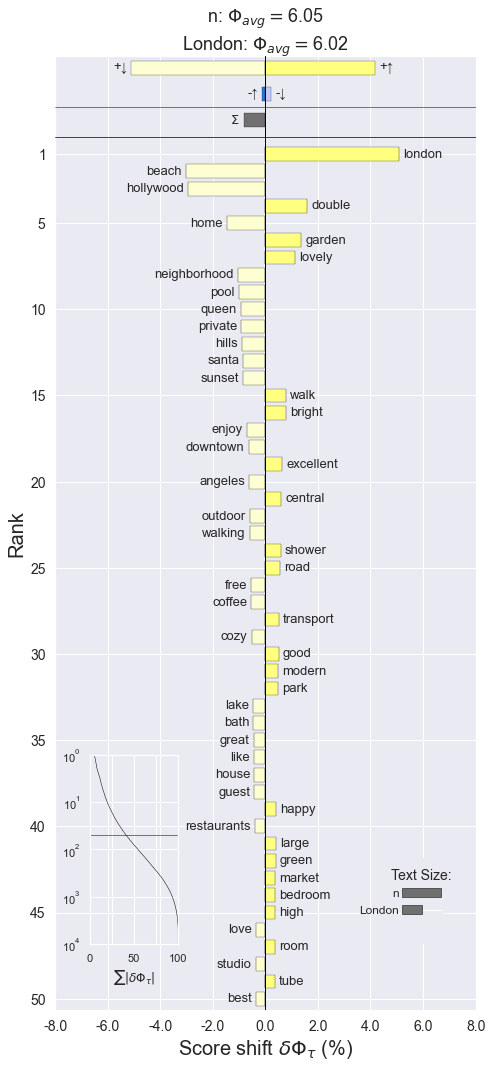

In [48]:
plot_shift(CITY_TERMS.join(VOCAB.n).T, 'n', 'London')

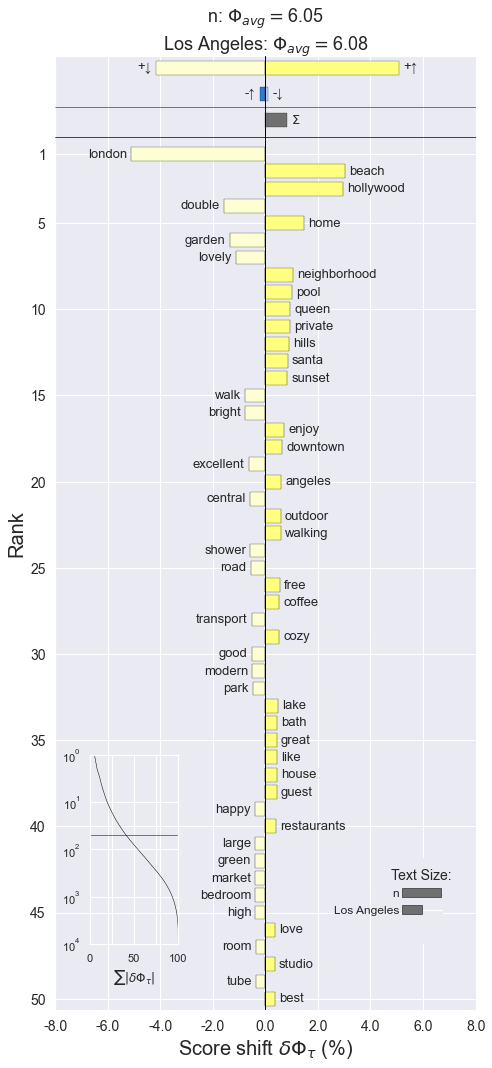

In [49]:
plot_shift(CITY_TERMS.join(VOCAB.n).T, 'n', 'Los Angeles')